# Data analysis on main phase 2+1D CDT

Author: Seda den Boer

Date: 04/04/2024

In [53]:
# Load packages
import sys
sys.path.append('..')
from classes.universe import Universe
from classes.helper_functions.helpers import get_spatial_neighbours, get_vertices_in_slice
from typing import Dict, List
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import os
from mpl_toolkits.mplot3d import Axes3D
import random

## Experiment parameters

In [54]:
chains = 5
k0_values = np.arange(0.0, 8.0, 1.0)
T = 3
thermal_sweeps = 100
sweeps = 0
target_volume = 3000
ksteps = 300000

# k0 to make plots for
k0 = 6.0

## $k_3$

### Critical $k_3$

In [55]:
last_k3 = {k: [] for k in k0_values}

for k in k0_values:
    for chain in range(chains):
        k = float(k)
        filepath = f'measurements/k0={k}/T{T}_k0={k}_tswps={thermal_sweeps}_swps={sweeps}_kstps={ksteps}_chain={chain}_k3_values.npy'
        k3_values = np.load(filepath)

        # Get final value in the dataset
        last_k3[k].append(k3_values[-1])
    
# Make it a df 
df_critical_k3 = pd.DataFrame(last_k3).T
df_critical_k3.index.name = 'k0'
df_critical_k3.columns.name = 'chain'
df_critical_k3['mean'] = df_critical_k3.mean(axis=1)
df_critical_k3['std'] = df_critical_k3.std(axis=1)
df_critical_k3

chain,0,1,2,3,4,mean,std
k0,,,,,,,
0.0,0.98382,0.95398,0.95790,0.95410,0.95300,0.960560,0.011750
1.0,1.07320,1.06920,1.06610,1.13390,1.07028,1.082536,0.025782
2.0,1.21648,1.21648,1.22130,1.21718,1.22598,1.219484,0.003711
3.0,1.37940,1.38190,1.37850,1.38758,1.38280,1.382036,0.003187
4.0,1.52896,1.52302,1.51548,1.49158,1.52282,1.516372,0.013112
5.0,1.69202,1.69886,1.68512,1.70268,1.68652,1.693040,0.006828
6.0,1.88914,1.88828,1.89000,1.88850,1.88746,1.888676,0.000853
7.0,2.14012,2.13748,2.13934,2.13922,2.13976,2.139184,0.000910


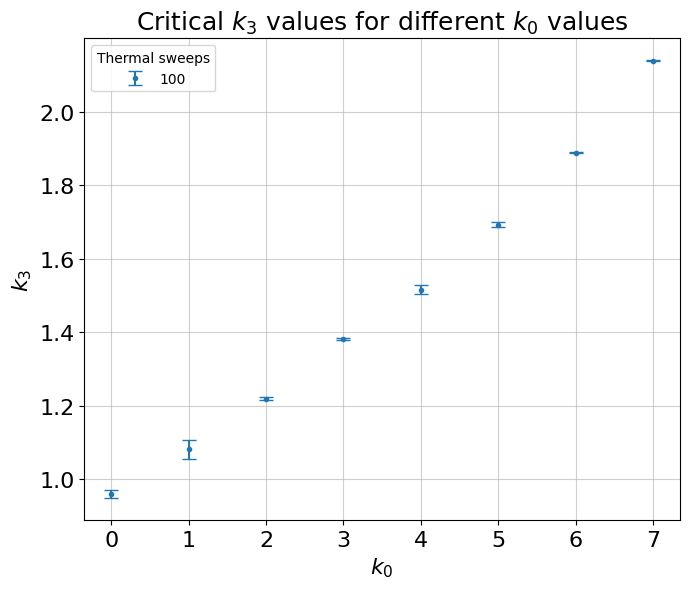

In [56]:
# Plot critical k3 with markers and interpolated line
plt.figure(figsize=(7, 6))
plt.errorbar(df_critical_k3.index, df_critical_k3['mean'], yerr=df_critical_k3['std'], fmt='.', capsize=5, xerr=None, label=100)
plt.title('Critical $k_3$ values for different $k_0$ values', fontsize=18)
plt.xlabel('$k_0$', fontsize=16)
plt.ylabel('$k_3$', fontsize=16)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.grid(True, which="both", ls="-", alpha=0.6)
plt.legend(title='Thermal sweeps', fancybox=True)
plt.tight_layout()
savepath = f'plots/k3_tuning/critical_k3_values.png'
if not os.path.exists('plots/k3_tuning'):
    os.makedirs('plots/k3_tuning')
plt.savefig(savepath, dpi=400, bbox_inches='tight')

## $<N_{22}/N_{31}>$

### Phase transition

## Volume

### Spatial volume

### Total tetrahedron volume

## Curvature

## Spectral dimension

In [57]:
def plot_spectral_dimension_per_timeslice(infile: str, diffusion_times: List[int]):
    pass

def plot_spectral_dimension(infile: str, diffusion_times: List[int]):
    pass

## Visualisation

### Network timeslices

In [58]:
def generate_timeslice_graphs(universe: Universe, save: bool, filename: str) -> Dict[int, nx.Graph]:
    T = universe.n_slices
    vertices_in_slice = get_vertices_in_slice(universe)
    spatial_neighbours = get_spatial_neighbours(universe)
    graphs = {t: None for t in range(T)}

    # Generate the graph
    for t, vertex_ids in vertices_in_slice.items():
        G = nx.Graph()

        for vertex_id in vertex_ids:
            vertex = universe.vertex_pool.get(vertex_id)
            G.add_node(
                vertex_id,
                time=vertex.time,
                tetrahedron=vertex.tetra.ID,
                degree=len(universe.vertex_neighbours[vertex.ID]),
                cnum=vertex.cnum,
                scnum=vertex.scnum,
            )
        
        for vertex_id in vertex_ids:
            for spatial_neighbour_id in spatial_neighbours[vertex_id]:
                G.add_edge(vertex_id, spatial_neighbour_id)

        pos = nx.planar_layout(G)
        print(pos)
        for node,(x,y) in pos.items():
            G.nodes[node]['x'] = float(x)
            G.nodes[node]['y'] = float(y)

        graphs[t] = G

        if nx.check_planarity(G):
            print(f'The spatial slice {t} is planar')
        else:
            print(f'The spatial slice {t} is not planar')
            
        if save:
            nx.write_gexf(G, f'{filename}_t={t}.gexf')
    
    return graphs

def visualise_timeslices(graphs: Dict[int, nx.Graph]):
    # Plot each graph
    for t in range(len(graphs)):
        G = graphs[t]

        if G:
            plt.figure()
            pos = nx.spring_layout(G)
            nx.draw(G, pos, node_size=1, node_color="blue")
            plt.title(f"Time slice {t}")
            plt.axis("equal")

In [59]:
# universe_0 = Universe(geometry_infilename=filenames[0])
# graphs = generate_timeslice_graphs(universe_0, True, 'networks/graph_k0=0')

### Triangulation timeslices

In [85]:
def f(x, data):
    return data[-1][x]

In [87]:
# for chain in range(chains):
#     for k in k0_values:
#         filepath = f'measurements/k0={k}/T{T}_k0={k}_tswps={thermal_sweeps}_swps={sweeps}_kstps={ksteps}_chain={chain}_slice_sizes.npy'
#         slice_sizes = np.load(filepath)

#         # Generate points along the function
#         x = np.arange(T)
#         y = [f(x, slice_sizes) for x in x]

#         # Revolve the profile around an axis
#         theta = np.linspace(0, 2 * np.pi, 100)
#         X, Theta = np.meshgrid(x, theta)
#         Y = np.cos(Theta) * y
#         Z = np.sin(Theta) * y

#         # Plot the 3D object
#         fig = plt.figure()
#         ax = fig.add_subplot(111, projection='3d')
#         ax.plot_surface(X, Y, Z, color='b', alpha=0.8)
#         ax.set_xlabel('Time slice')
#         ax.set_title(f'Spatial volume distribution for $k_0={k}$')
#         ax.set_yticks([])
#         ax.set_zticks([])
#         ax.set_xticks(x)
#         savepath = f'plots/visualisation/spatial_volume_k0={k}_chain={chain}.png'
#         if not os.path.exists('plots/visualisation'):
#             os.makedirs('plots/visualisation')
#         plt.savefig(savepath, dpi=400, bbox_inches='tight')

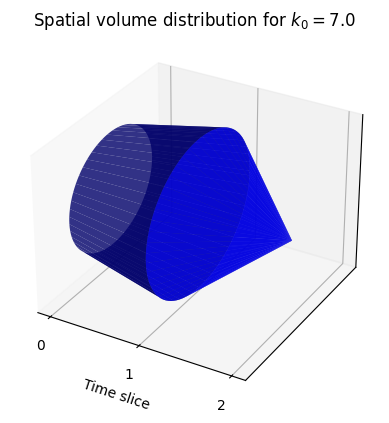

In [92]:
chain = 2
k0 = 7.0
filepaths = []
for k in k0_values:
    filepaths.append(f'measurements/k0={k}/T{T}_k0={k}_tswps={thermal_sweeps}_swps={sweeps}_kstps={ksteps}_chain={chain}_slice_sizes.npy')
slice_sizes = [np.load(filepath) for filepath in filepaths]

# Step 2: Generate points along the function
x = np.arange(T)
y = [f(x, slice_sizes[int(k0)]) for x in x]

# Revolve the profile around an axis
theta = np.linspace(0, 2 * np.pi, 100)
X, Theta = np.meshgrid(x, theta)
Y = np.cos(Theta) * y
Z = np.sin(Theta) * y

# Plot the 3D object
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, color='b', alpha=0.8)
ax.set_xlabel('Time slice')
ax.set_title(f'Spatial volume distribution for $k_0={k0}$')
ax.set_yticks([])
ax.set_zticks([])
ax.set_xticks(x)
savepath = f'plots/visualisation/spatial_volume_k0={k0}_chain={chain}.png'
if not os.path.exists('plots/visualisation'):
    os.makedirs('plots/visualisation')
plt.savefig(savepath, dpi=400, bbox_inches='tight')

[]

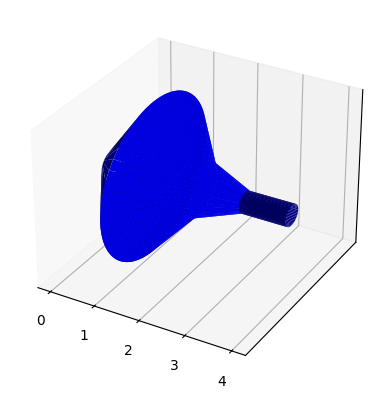

In [61]:
def generate_random_data(length, total):
    data = []
    remaining = total
    for _ in range(length - 1):
        value = random.uniform(0, remaining)
        data.append(value)
        remaining -= value
    data.append(remaining)
    random.shuffle(data)
    return data

# Step 2: Generate points along the function
x = [0, 1, 2, 3, 4]
length = 5
total = 5000
y = generate_random_data(length, total)

# Step 3: Revolve the profile around an axis
theta = np.linspace(0, 2 * np.pi, 100)
X, Theta = np.meshgrid(x, theta)
Y = np.cos(Theta) * y
Z = np.sin(Theta) * y

# Step 4: Plot the 3D object
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, color='b')
# Dont show y and z axis
ax.set_yticks([])
ax.set_zticks([])